<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_Hyperbolic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE with the Hyperbolic Wrapped distribution

Variational Autoencoder Model (VAE) (https://arxiv.org/pdf/1312.6114.pdf) with the Hyperbolic Wrapped distribution 

https://github.com/pfnet-research/hyperbolic_wrapped_distribution

https://arxiv.org/abs/1902.02992.

In [1]:
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


# Generate binary tree

In [0]:
def hasone(node_index, dim_index):
    bin_i, bin_j = np.binary_repr(node_index), np.binary_repr(dim_index)
    length = len(bin_j)
    return (bin_i[:length] == bin_j) * 1

def hamming_distance(x, y):
    return (x.astype(np.int32) ^ y.astype(np.int32)).sum()

def euclid_distance(x, y):
    return np.sqrt(((x - y)**2).sum(axis=-1))

def get_data(depth, dtype=np.float32):
    n = 2**depth - 1
    x = np.fromfunction(lambda i, j: np.vectorize(hasone)(i + 1, j + 1),
                        (n, n), dtype=np.int32).astype(dtype)
    return x

def get_example(data, i, eps):
  filter_ = np.random.random(size=data.shape[-1]) < eps
  return (data[i,:].astype(bool) ^ filter_).astype(data.dtype)

In [0]:
my_data = []
labels = []
true_data = get_data(4)
for i in range(true_data.shape[0]*50):
  one_example = get_example(true_data, i % true_data.shape[0], eps=0.001)
  labels.append(i%true_data.shape[0])
  my_data.append(one_example)

In [0]:
X = np.array(my_data)
y = np.array(labels)

In [0]:
y_levels = np.copy(y)
for i in range(y.shape[0]):
  if y[i] == 0:
    y_levels[i] = 0
  elif 1<= y[i] <= 2:
    y_levels[i] = 1
  elif 3<= y[i] <= 6:
    y_levels[i] = 2
  elif 7<= y[i] <= 14:
    y_levels[i] = 3
  elif 15<=y[i] <= 30:
    y_levels[i] = 4

In [123]:
X.shape

(750, 15)

# Helper functions

In [0]:
def project_2D(z):
  t = z[:,0][:,np.newaxis]
  x = z[:,1:]
  y = x/(1+t)
  return y

In [0]:
eps=1e-12

def clamp(a, a_min):
    """checked"""
    return tf.nn.relu(a - a_min) + a_min

def negate_first_index(x):
    """checked"""
    x0, xrest = tf.split(x, num_or_size_splits=[1,tf.shape(x)[-1]-1], axis=-1)
    return tf.concat((x0 * -1, xrest), axis=-1)
  
def lorentzian_product(u, v=None, keepdims=False):
    """checked"""
    if v is None:
        v = u
    uv = u * v
    return tf.reduce_sum(negate_first_index(uv), axis=-1, keepdims=keepdims)

def lorentz_distance(u, v, keepdims=False):
    """checked
    arccosh(x) = ln[x+sqrt(x^2-1)]"""
    x = -lorentzian_product(u, v, keepdims=keepdims)
    return tf.math.log(clamp(x + tf.math.sqrt(clamp(x**2 - 1, eps)), eps))

def inv_exponential_map(x, z):
    """checked
    Eq. (14)"""
    alpha = -lorentzian_product(x, z, keepdims=True)
    C = lorentz_distance(x, z, keepdims=True)/tf.math.sqrt(clamp(alpha ** 2 - 1, eps))
    return C * (z - alpha * x)

def exponential_map(x, v):
    """checked"""
    vnorm = tf.math.sqrt(clamp(lorentzian_product(v, keepdims=True), eps))
    return tf.math.cosh(vnorm) * x + tf.math.sinh(vnorm) * v / vnorm  
  
def parallel_transport(xi, x, y):
    """checked
    Eq. (15)
    """
    alpha = -lorentzian_product(x, y, keepdims=True)
    coef = lorentzian_product(y - alpha * x, xi, keepdims=True) / (alpha + 1)
    return xi + coef * (x + y)
  
def algo1(mu, epsilon):
  """checked"""
  mu_0 = tf.concat((tf.ones(shape=[tf.shape(mu)[0], 1]), tf.zeros(shape=[tf.shape(mu)[0], tf.shape(mu)[1]-1])), axis=-1) #origin
  v = tf.concat((tf.zeros(shape=[tf.shape(mu)[0], 1]), epsilon), axis=-1)
  u = parallel_transport(v, mu_0, mu)
  z = exponential_map(mu, u)
  return z

def algo2(z, mu):
  """Output:
  v1 - point sampled from original distribution
  r - the distance used for detlog."""
  mu_0 = tf.concat((tf.ones(shape=[tf.shape(mu)[0], 1]), tf.zeros(shape=[tf.shape(mu)[0], tf.shape(mu)[1]-1])), axis=-1) #origin
  u = inv_exponential_map(mu, z)
  v = parallel_transport(u, mu, mu_0) #move to the origin
  v_tilde = v[:,1:] #omit the first coordinate which is zero
  r = tf.math.sqrt(clamp(lorentzian_product(u, keepdims=True), eps))
  return v_tilde, r

In [0]:
def create_encoder(inpt, latent_size, activation, reg):
  x = inpt
  x = tf.layers.dense(x, 16, activation, kernel_regularizer=reg)
  x = tf.layers.dense(x, 10, activation, kernel_regularizer=reg)
  x = tf.layers.dense(x, 8, activation, kernel_regularizer=reg)
  x = tf.layers.dense(x, 6, activation, kernel_regularizer=reg)
  x = tf.layers.dense(x, 4, activation, kernel_regularizer=reg)
  
  h = tf.layers.dense(x,latent_size, kernel_regularizer=reg)
  #h = tf.clip_by_norm(h, clip_norm = 500.0, axes=-1)
  mu1 = tf.math.cosh(tf.norm(h, axis=-1, keep_dims=True))
  mu2 = h*tf.math.sinh(tf.norm(h, axis=-1, keep_dims=True))/(tf.norm(h, axis=-1, keep_dims=True)+eps)
  mu = tf.concat((mu1, mu2),axis=-1)
  
  sigma = tf.layers.dense(x,2, kernel_regularizer=reg)
  sigma = tf.math.softplus(sigma)
  return mu, sigma

def create_prior(latent_size):
  return tf.constant([1.0, 0.0, 0.0]), 1.0*tf.ones(latent_size)

def create_decoder(inpt, output_size, activation, reg):
  x = inpt
  x = tf.layers.dense(x, 4, activation, kernel_regularizer=reg)
  x = tf.layers.dense(x, 6, activation, kernel_regularizer=reg)
  x = tf.layers.dense(x, 8, activation, kernel_regularizer=reg)
  x = tf.layers.dense(x, 10, activation, kernel_regularizer=reg)
  x = tf.layers.dense(x, 16, activation, kernel_regularizer=reg)
  theta = tf.layers.dense(x, output_size, kernel_regularizer=reg)
  return tfd.Independent(tfd.Bernoulli(theta), 1)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x')
latent_size = 2

mu, sigma = create_encoder(x, latent_size, tf.nn.elu, regularizers.l1_l2(l1=0.0, l2=0.001))

sigma = 0.2*tf.ones(latent_size)


mu_prior, sigma_prior = create_prior(latent_size)
mu_prior = tf.reshape(mu_prior, shape=[1,-1])
mu_prior = tf.ones(shape=[tf.shape(mu)[0], latent_size+1])*mu_prior

zero_vec = tf.zeros(shape=[tf.shape(mu)[0], tf.shape(mu)[1]-1])
dist_latent = tfd.MultivariateNormalDiag(loc=zero_vec, scale_diag=sigma)
dist_prior = tfd.MultivariateNormalDiag(loc=zero_vec, scale_diag=sigma_prior)
epsilon = dist_latent.sample()
latent_sampled = algo1(mu, epsilon)

v_latent, r_latent = algo2(latent_sampled, mu)
v_prior, r_prior = algo2(latent_sampled, mu_prior)

log_latent_posterior = dist_latent.log_prob(v_latent) - (latent_size-1)*tf.math.log(1e-12+tf.math.sinh(r_latent)/(r_latent+1e-12))
log_prior = dist_prior.log_prob(v_prior) - (latent_size-1)*tf.math.log(1e-12+tf.math.sinh(r_prior)/(r_prior+1e-12))
kl = tf.reduce_mean(log_latent_posterior-log_prior)

beta = tf.placeholder(tf.float32, name='beta')
kl_loss = beta*kl

posterior = create_decoder(latent_sampled, X.shape[1], tf.nn.elu, regularizers.l1_l2(l1=0.0, l2=0.001))

posterior_sampled = posterior.sample()
posterior_mean = posterior.mean()

rec_loss = -tf.reduce_mean(posterior.log_prob(x))
reg_loss = tf.losses.get_regularization_loss()
loss = rec_loss + kl_loss + reg_loss
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

In [0]:
#Helper function
def batch_generator(features, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:]

In [240]:
n_epochs = 200
batch_size = 25
start = time.time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    if i < 100:
      beta_0 = 0.1
    else:
      beta_0 = 0.1+0.7*(i+1)/n_epochs
    gen = batch_generator(X, batch_size) #create batch generator
    total_loss = 0
    total_rec_loss = 0
    for j in range(np.int(X.shape[0]/batch_size)):
      x_batch = gen.__next__()
      _, total_loss_, total_rec_loss_ = sess.run([optimizer, loss, rec_loss], feed_dict={x: x_batch, beta: beta_0})
      total_loss += total_loss_
      total_rec_loss += total_rec_loss_
    if (i+1)% 10 == 0 or i == 0:
      #latent_mean_, latent_sampled_, posterior_mean_, posterior_sampled_= sess.run([latent_mean, latent_sampled, posterior_mean, posterior_sampled], feed_dict ={x:X})
      end = time.time()
      print('epoch: {0}, total_loss: {1:.2f}, rec_loss: {2:.2f}, time: {3:.2f}'.format((i+1), 
                                       total_loss/(1+np.int(X.shape[0]/batch_size)), total_rec_loss/(1+np.int(X.shape[0]/batch_size)), end-start))
      start = time.time()
  latent_sampled_, mu_, posterior_mean_, posterior_sampled_= sess.run([latent_sampled, mu, posterior_mean, posterior_sampled], feed_dict ={x:X})

epoch: 1, total_loss: 9.90, rec_loss: 9.56, time: 1.70
epoch: 10, total_loss: 3.23, rec_loss: 2.63, time: 2.58
epoch: 20, total_loss: 1.87, rec_loss: 1.17, time: 2.94
epoch: 30, total_loss: 1.24, rec_loss: 0.50, time: 2.85
epoch: 40, total_loss: 1.02, rec_loss: 0.31, time: 2.90
epoch: 50, total_loss: 0.92, rec_loss: 0.24, time: 2.83
epoch: 60, total_loss: 0.85, rec_loss: 0.20, time: 2.93
epoch: 70, total_loss: 0.82, rec_loss: 0.18, time: 2.82
epoch: 80, total_loss: 0.80, rec_loss: 0.18, time: 2.82
epoch: 90, total_loss: 0.78, rec_loss: 0.16, time: 2.84
epoch: 100, total_loss: 0.78, rec_loss: 0.17, time: 2.83
epoch: 110, total_loss: 2.16, rec_loss: 0.37, time: 2.88
epoch: 120, total_loss: 2.23, rec_loss: 0.37, time: 2.78
epoch: 130, total_loss: 2.31, rec_loss: 0.34, time: 2.86
epoch: 140, total_loss: 2.42, rec_loss: 0.36, time: 2.79
epoch: 150, total_loss: 2.52, rec_loss: 0.39, time: 2.79
epoch: 160, total_loss: 2.60, rec_loss: 0.40, time: 2.78
epoch: 170, total_loss: 2.69, rec_loss: 0.

In [0]:
disk = project_2D(latent_sampled_)
mu_d = project_2D(mu_)
t = np.linspace(0,1,5000)
x_c = np.cos(2*np.pi*t)
y_c = np.sin(2*np.pi*t)

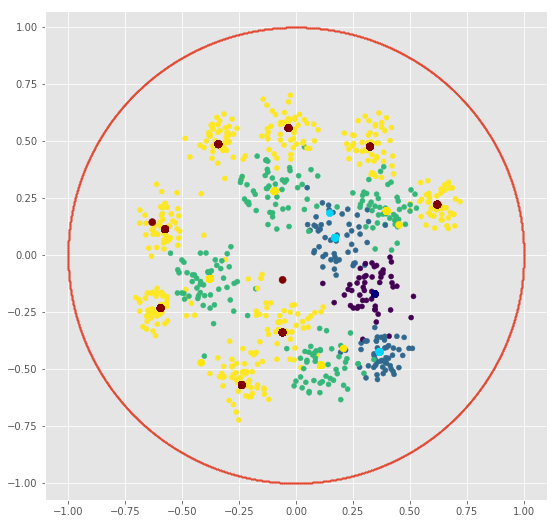

In [242]:
plt.figure(figsize=(9,9))
plt.scatter(disk[:,0], disk[:,1], c=y_levels, s=25.0, cmap='viridis');
plt.scatter(mu_d[:,0], mu_d[:,1], c=y_levels, s=50.0, cmap='jet');
plt.scatter(x_c, y_c, s=1.0);
plt.axis('equal');

In [0]:
def map_to_zero(z, a):
  return (z-a)/(1-np.conjugate(a)*z)

In [0]:
a = mu_d[0,0]+mu_d[0,1]*1.0j
mu_c = mu_d[:,0]+mu_d[:,1]*1.0j
disk_c = disk[:,0]+disk[:,1]*1.0j
mu_r = map_to_zero(mu_c, a)
disk_r = map_to_zero(disk_c, a)

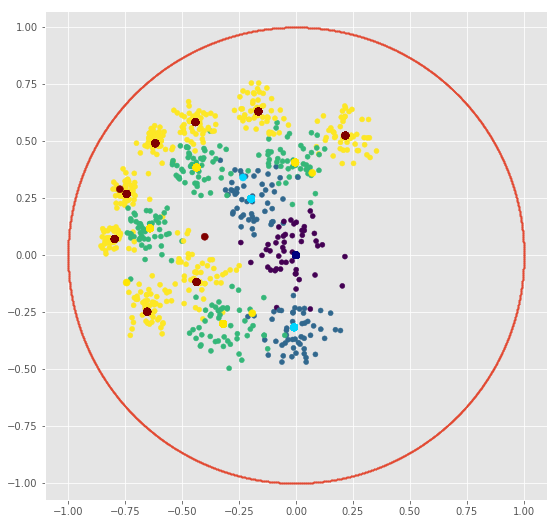

In [245]:
plt.figure(figsize=(9,9))
plt.scatter(disk_r.real, disk_r.imag, c=y_levels, s=25.0, cmap='viridis');
plt.scatter(mu_r.real, mu_r.imag, c=y_levels, s=50.0, cmap='jet');
plt.scatter(x_c, y_c, s=1.0);
plt.axis('equal');